In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
# matplotlib.rcParams['figure.figsize'] = 12, 18

## let's do it!

### Goal 1: get pictures for calibration

In [1]:
import cv2
import matplotlib.pyplot as plt

def webcam_take_pics(mirror=False):
    cam = cv2.VideoCapture(0)
    i = 1
    while True:
        ret_val, img = cam.read()
        if mirror: 
            img = cv2.flip(img, 1)
        cv2.imshow('my webcam', img)
        if cv2.waitKey(1) == 13:
            cv2.imwrite('webcam/calib{:>05}.jpg'.format(i), img)
            print(i, "Images stored...")
            i = i+1
        
        if cv2.waitKey(1) == 27:
            plt.imshow(img)#just to show the result at the end
            break  # esc to quit
    cv2.destroyAllWindows()

0 Images stored...
1 Images stored...
2 Images stored...
3 Images stored...
4 Images stored...
5 Images stored...
6 Images stored...
7 Images stored...
8 Images stored...
9 Images stored...
10 Images stored...
11 Images stored...
12 Images stored...


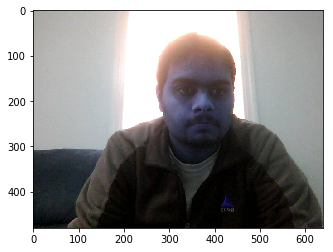

In [2]:
webcam_take_pics()

## Once you have images, start from here!

In [1]:
# Define No of corners 
# don's count black and white squares
# count intersection in length and width

length = 7
width = 9

In [4]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt


# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((length * width, 3), np.float32)
objp[:, :2] = np.mgrid[0:width, 0:length].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane.

images = glob.glob('webcam/*.jpg')
outs = []

for fname in images:
    img = plt.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (width, length),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11, 11),(-1, -1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (width, length), corners2, ret)
        outs.append(img)

total = len(outs)
for i, out in enumerate(outs):
    try:
#         plt.subplot(total // 2, 2, i + 1)
        plt.imshow(out)
        plt.show()
    except: break

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

### Goal 2: Find Camera matrix

In [5]:
# find camera matrix, distorition coefficients etc
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Now we can undistort our image
img = cv2.imread("webcam/calib00001.jpg")
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
x, y, w, h = roi

### Goal 3: Undistort the image

In [6]:
print("camera matrix",mtx,"\n")
print("Distortion",dist)

camera matrix [[516.9288276    0.         344.81935033]
 [  0.         522.61949852 302.93628475]
 [  0.           0.           1.        ]] 

Distortion [[-0.06152242  0.14565494  0.01983269  0.01307263 -0.43901171]]


In [7]:
# Reprojection error to find accuracy of estimated parameters
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    mean_error += error

print("total error: %.4f %%" % (mean_error / len(objpoints)))

total error: 0.1353 %


## Let's do some cool stuff!

In [8]:
# Function that draws on image
def draw(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]], -1, (0, 255, 0), -3)

    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255), 3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]], -1, (0, 0, 255), 3)

    return img

In [9]:
# parameters for visualization
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((length * width, 1, 3), np.float32)
objp[:, :, :2] = np.mgrid[0:width, 0:length].T.reshape(-1, 1, 2)

offset = [2.5, 1.5,0]
size = 2

# PS: The sequence of the points matters!
# and also axis is not axis it is just points!!!
axis = np.float32([[0, 0, 0], [0, size, 0], [size, size, 0], [size, 0, 0],
                   [0, 0, -1*size],[0, size, -1*size],[size, size, -1*size],[size, 0, -1*size]])

axis = axis + offset
outs = []

## Interactive way of visualization (Nice!!)

In [17]:
import cv2
import matplotlib.pyplot as plt

def webcam_feed_AR(mirror=False):
    cam = cv2.VideoCapture(0)
    while True:
        ret_val, img = cam.read()
        if mirror: 
            img = cv2.flip(img, 1)
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (width, length),None)

        if ret == True:
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

            # Find the rotation and translation vectors.
            _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)

            # project 3D points to image plane
            imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

            img = draw(img, corners2, imgpts)
            cv2.imshow("yeah AR!", img)

        if cv2.waitKey(1) == 27:
            plt.imshow(img)#just to show the result at the end
            break  # esc to quit
    cv2.destroyAllWindows()

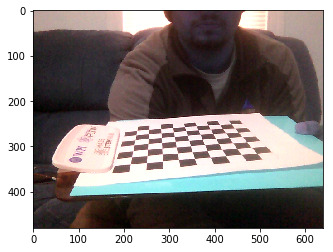

In [22]:
webcam_feed_AR()

## Un-interactive way for visualization (aww!)

In [ ]:

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (width, length),None)

    if ret == True:
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

        # Find the rotation and translation vectors.
        _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)

        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        
        img = draw(img, corners2, imgpts)
        outs.append(img)

for i, out in enumerate(outs):
    try:
        plt.imshow(out)
        plt.show()
    except: break

# Experiment: Let's Move it!

In [18]:
import cv2
import matplotlib.pyplot as plt
import math

def webcam_experiment(mirror=False):
    cam = cv2.VideoCapture(0)
    i = 1
    
    while True:
        offset = [6*math.cos(i), 6*math.sin(i),0]
        i = i + 0.1
        size = 2

        # PS: The sequence of the points matters!
        # and also axis is not axis it is just points!!!
        axis = np.float32([[0, 0, 0], [0, size, 0], [size, size, 0], [size, 0, 0],
                           [0, 0, -1*size],[0, size, -1*size],[size, size, -1*size],[size, 0, -1*size]])

        axis = axis + offset
        ret_val, img = cam.read()
        if mirror: 
            img = cv2.flip(img, 1)
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (width, length),None)

        if ret == True:
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

            # Find the rotation and translation vectors.
            _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)

            # project 3D points to image plane
            imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

            img = draw(img, corners2, imgpts)
            cv2.imshow("yeah AR!", img)

        if cv2.waitKey(1) == 27:
            plt.imshow(img)#just to show the result at the end
            break  # esc to quit
    cv2.destroyAllWindows()

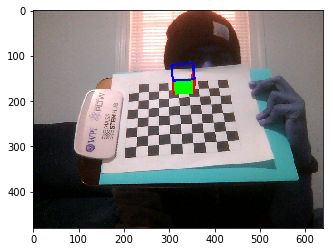

In [19]:
webcam_experiment()

# Experiment 2: HEXAGON

In [20]:
# Function that draws on image
def draw_hexa(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:6]], -1, (0, 255, 0), -3)

    # draw pillars in blue color
    for i,j in zip(range(6),range(6,12)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255), 3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[6:]], -1, (0, 0, 255), 3)

    return img

In [27]:
import cv2
import matplotlib.pyplot as plt
import math

def webcam_experiment(mirror=False):
    cam = cv2.VideoCapture(0)
    i = 1
    
    while True:
        offset = [3+ 2*math.sin(i) ,3+2*math.cos(i),0]
        i = i + 0.1
        size = 2

        # PS: The sequence of the points matters!
        # and also axis is not axis it is just points!!!
        axis = np.float32([[size, 0, 0], [size/2, size*0.865, 0], [-1*size/2, size*0.865, 0],
                           [-1*size, 0, 0], [-1*size/2, -1*size*0.865, 0], [size/2,-1*size*0.865, 0],
                           [size, 0, -1*size], [size/2, size*0.865, -1*size], [-1*size/2, size*0.865, -1*size],
                           [-1*size, 0, -1*size], [-1*size/2, -1*size*0.865, -1*size], [size/2,-1*size*0.865, -1*size]])
                           
        axis = axis + offset
        ret_val, img = cam.read()
        if mirror: 
            img = cv2.flip(img, 1)
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (width, length),None)

        if ret == True:
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

            # Find the rotation and translation vectors.
            _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)

            # project 3D points to image plane
            imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

            img = draw_hexa(img, corners2, imgpts)
            cv2.imshow("yeah AR!", img)

        if cv2.waitKey(1) == 27:
            plt.imshow(img)#just to show the result at the end
            break  # esc to quit
    cv2.destroyAllWindows()

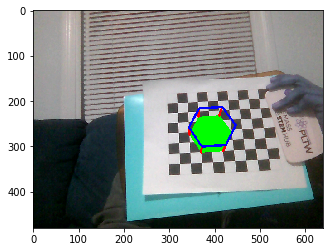

In [28]:
webcam_experiment()

# Experiment 3: transformation matrix

In [52]:
import cv2
import matplotlib.pyplot as plt
import math

def webcam_experiment(mirror=False):
    cam = cv2.VideoCapture(0)
    i = 1
    
    while True:
        offset = [6*math.cos(i), 6*math.sin(i),0]
        i = i + 0.1
        rotate = np.matrix([[math.cos(i), -1*math.sin(i), 0], [math.sin(i), math.cos(i), 0], [0, 0, 1]])
        
        size = 2

        # PS: The sequence of the points matters!
        # and also axis is not axis it is just points!!!
        axis = np.float32([[0, 0, 0], [0, size, 0], [size, size, 0], [size, 0, 0],
                           [0, 0, -1*size],[0, size, -1*size],[size, size, -1*size],[size, 0, -1*size]])

        axis = axis * rotate
        axis = axis + offset
       
        ret_val, img = cam.read()
        if mirror: 
            img = cv2.flip(img, 1)
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (width, length),None)

        if ret == True:
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

            # Find the rotation and translation vectors.
            _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)

            # project 3D points to image plane
            imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

            img = draw(img, corners2, imgpts)
            cv2.imshow("yeah AR!", img)

        if cv2.waitKey(1) == 27:
            plt.imshow(img)#just to show the result at the end
            break  # esc to quit
    cv2.destroyAllWindows()

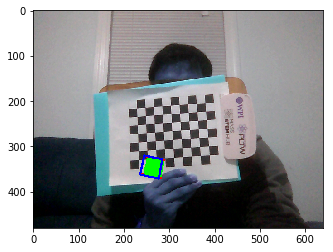

In [53]:
webcam_experiment()